# `NMF visualization`

Modified from the pyLDAvis scikit-learn example notebook.

In [1]:
import re, io, os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
import urllib.request
import random
random.seed(13)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

## Helper Functions

In [3]:
def tokenize(data):
    index = defaultdict(str)
    
    with urllib.request.urlopen(data) as file:
        for line in file.read().decode('latin-1').splitlines():
            # pull out takahashi lines
            m = re.match(r'^<(f.*?)\..*;H> +(\S.*)$', line)
            if not m:
                continue

            transcription = m.group(2)
            pg = str(m.group(1))

            # ignore entire line if it has a {&NNN} or {&.} code
            if re.search(r'\{&(\d|\.)+\}', transcription):
                continue

            # remove extraneous chracters ! and %
            s = transcription.replace("!", "").replace("%", "")
            
            # delete all end of line {comments} (between one and three observed)
            # ...with optional line terminator
            # allow 0 occurences to remove end-of-line markers (- or =)
            s = re.sub(r'([-=]?\{[^\{\}]+?\}){0,3}[-=]?\s*$', "", s)

            # delete start of line {comments} (single or double)
            s = re.sub(r'^(\{[^\{\}]+?\}){1,2}', "", s)

            # simplification: tags preceeded by -= are word breaks
            s = re.sub(r'[-=]\{[^\{\}]+?\}', '.', s)

            # these tags are nulls
            # plant is a null in one case where it is just {plant}
            # otherwise (above) it is a word break
            # s = re.sub(r'\{(fold|crease|blot|&\w.?|plant)\}', "", s)
            # simplification: remaining tags in curly brackets
            s = re.sub(r'\{[^\{\}]+?\}', '', s)

            # special case .{\} is still a word break
            s = re.sub(r'\.\{\\\}', ".", s)

            # split on word boundaries
            # exclude null words ('')
            words = [str(w) for w in s.split(".") if w]
            paragraph = ' '.join(words).lstrip()
            
            index[pg] += (paragraph)

    return index


In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

## Load Voynich Data

Load the Pickle files produced by vms_vectorize.py

In [46]:
models_path = "./models"

# load in the pickle files of stored models
with open("{}/tfidf_vectorizer.pk".format(models_path), "rb") as f:
    tfidf_vectorizer = pickle.load(f)
with open("{}/vms_tf.pk".format(models_path), "rb") as f:
    vms_tf = pickle.load(f)
with open("{}/vms_mapping.pk".format(models_path), "rb") as f:
    vms_mapping = pickle.load(f)
with open("{}/tf_vectorizer.pk".format(models_path), "rb") as f:
    tf_vectorizer = pickle.load(f)
with open("{}/vms_tfidf.pk".format(models_path), "rb") as f:
    vms_tfidf = pickle.load(f)

index = tokenize("https://raw.githubusercontent.com/rachelbari/voynich-topic-modeling/master/data/text16e6.evt")
documents = [index[key] for key in index.keys()]


/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Make a dict containing information about each page of the VMS

In [47]:
# a class for a single folio
# currently just contains state variables
# will eventually have a show() method to display the page
class Folio:
    def __init__(self, name, quire, topic="?", hand=0, lang="?"):
        self.name = name
        self.quire = int(quire)
        self.topic = topic
        self.hand = int(hand)
        self.lang = lang

In [48]:
lfd_map = pd.read_csv("./lfd_map.csv")
print(lfd_map)
vms = {}
for row in lfd_map.iterrows():
    folio = Folio(row[1].folio, row[1].quire, row[1].topic, row[1].hand, row[1].language)
    vms[folio.name] = folio

print(vms['f1r'].hand)

     folio               topic  hand language  quire
0      f1r           botanical     1        a      1
1      f1v           botanical     1        a      1
2      f2r           botanical     1        a      1
3      f2v           botanical     1        a      1
4      f3r           botanical     1        a      1
..     ...                 ...   ...      ...    ...
220  f114r  starred paragraphs     0        b     18
221  f114v  starred paragraphs     0        b     18
222  f115r  starred paragraphs     0        b     18
223  f115v  starred paragraphs     0        b     18
224  f116r  starred paragraphs     0        b     18

[225 rows x 5 columns]
1


## Fit NMF models

In [100]:
# for TF
#nmf_tf = LatentDirichletAllocation(n_topics=num_topics, random_state=0, max_iter=8)#, learning_method="online", learning_offset=20.)
#nmf_tf.fit(vms_tf)
# for TFIDF
num_topics = 2

# reset the topic labels
for key in vms.keys():
    vms[key].nmf_topic = 0

nmf_tfidf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_tfidf.fit(vms_tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_tfidf, tfidf_feature_names, 10)

nmf_embedding = nmf_tfidf.transform(vms_tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

# assign each page to its nearest topic, and log that in the vms dict
i = 0
for topic in nmf_embedding.argmax(axis=1):
    name = lfd_map['folio'].values[i]
    vms[name].nmf_topic = topic
    i += 1


Topic #0:
chedy shedy ol qokeedy qokedy qokain aiin qokeey ar qokaiin

Topic #1:
daiin chol chor shol chy cthy sho dy cthol shor



## Making sense of the data

Using techniques from https://www.kaggle.com/xdsarkar/nips-papers-visualized-with-nmf-and-t-sne

First, we transform the tfidf-matrix into an nmf-embedding, and look at which folios are most closely associated with each topic

In [103]:
top_n = 80 #how many pages

top_idx = np.argsort(nmf_embedding,axis=0)[-top_n:]

print(top_idx.T)

# output into a file
outfile = open('./out/map_'+str(num_topics)+'_topics_top_'+str(top_n)+'.txt', 'w') 

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    print("\nTopic {}:".format(count), file=outfile)
    for idx in np.flip(idxs): # they're in reverse order
        folio = vms_mapping[idx]
        # print twice to get both file output and stdout in the notebook
        print("("+str(vms[folio].nmf_topic)+") "+folio+": hand "+str(vms[folio].hand)+", language "+vms[folio].lang+", "+vms[folio].topic)
        print("("+str(vms[folio].nmf_topic)+") "+folio+": hand "+str(vms[folio].hand)+", language "+vms[folio].lang+", "+vms[folio].topic, file=outfile)
    count += 1
outfile.close()


[[ 59  79 138 184  96  63 185  49 106  78 131  62  76  97 187  82  48 113
  107 221 186  93 207  64 165 169 223 189  77 166  58 218 168  83 220  75
  164  74 116  65 205 222 204 206 167  89 219 210 209 208 214 217 211 157
  216 154 215 160 152 158 155 145 213 163 156 224 150 212 148 161 159 203
  151 202 147 162 153 149 144 146]
 [  8  56  32 192  10 174   7  44  72  52  22 101  69  16  12  39  23  86
   73  57 172 182 176  36  29  13  67  55   1  87  54  11  81  43  71  20
  103  42  68  31  66   4 177   2  91  41 197  94 196  25  70  85  14 194
  108  47 175   3  38 109   9  19  60  50  53  40  26  35  34  15   6  17
    0  37  61  18  80  95  27  90]]

Topic 0:
(0) f76r: hand 2, language b, balneological
(0) f75r: hand 2, language b, balneological
(0) f77v: hand 2, language b, balneological
(0) f79v: hand 2, language b, balneological
(0) f84r: hand 2, language b, balneological
(0) f76v: hand 2, language b, balneological
(0) f103r: hand 0, language b, starred paragraphs
(0) f78v: han

### Visualize the results with t-SNE

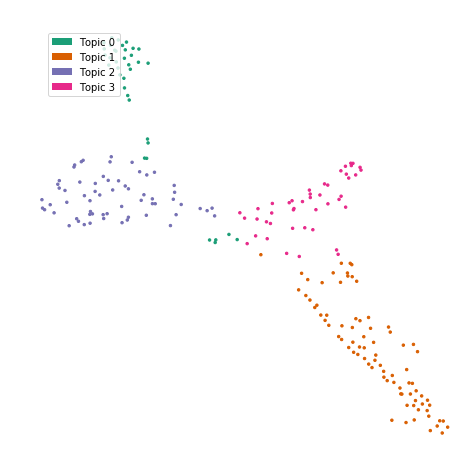

In [99]:
# set your colormap here
# https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
colormap = "Dark2"

# make a t-SNE embedding
tsne = TSNE()#pass in int random_state for deterministic behavior
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])

# get the colors to put in the legend
cmap = matplotlib.cm.get_cmap(colormap)
color_list = cmap(range(0, num_topics))
legend_list, topics = [], []
for i in range(num_topics): 
    legend_list.append(mpatches.Ellipse((0,0), 1, 1, fc=color_list[i]))
    topics.append("Topic "+str(i))
# now force these colors to be used in the plot
tsne_color = []
for i in nmf_embedding.argmax(axis=1): tsne_color.append(color_list[i])
tsne_embedding = tsne_embedding.assign(color= tsne_color)

# plot!
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.axis('off')
ax.scatter(x=tsne_embedding['x'], y=tsne_embedding['y'], s=6, c=tsne_embedding['color'])
fig.legend(legend_list, topics, loc=(0.1, 0.79))